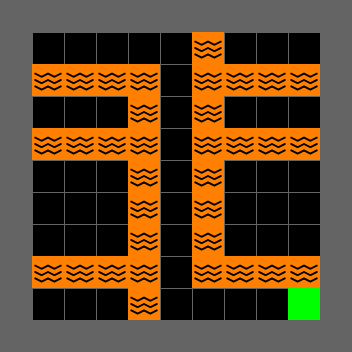

Obj Certainty Certainty, Average: 0.95


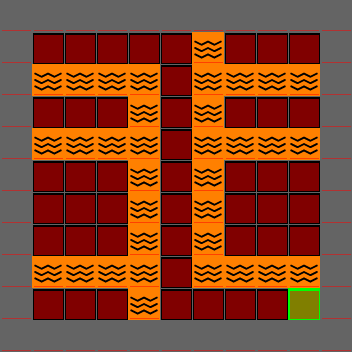

Color Certainty Certainty, Average: 0.97


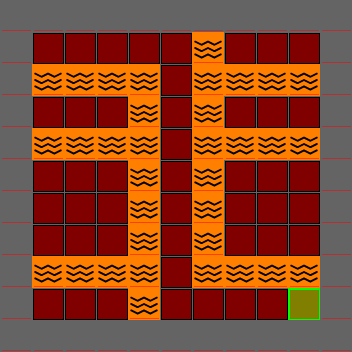

State Certainty Certainty, Average: 0.98


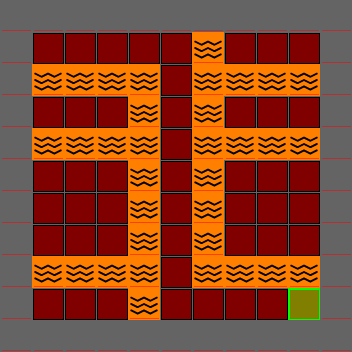

Agent Certainty Certainty, Average: 0.97


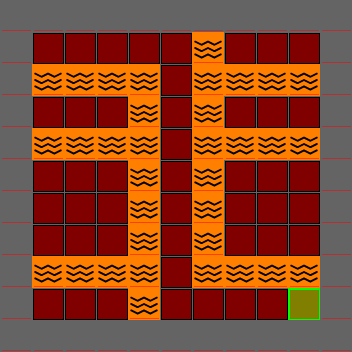

In [ ]:
import sys
sys.path.append('..')

# import minigrid
import gymnasium as gym
from minigrid.core.grid import Grid
from PIL import Image, ImageDraw
import numpy as np
import torch
from src.modules.training.datasets.two_d_dataset import TwoDDataset

# Create the environment
env = gym.make('MiniGrid-LavaCrossingS11N5-v0')
env.reset(seed=42)
env.reset()
info = {
    "env_build": {
        "observation_info": [(0, 10), (1, 6), (2, 3), (3, 5)],
        "action_info": [(0, 7)],
        "reward_info": [(0, 0)],
    },
}

# Get the grid
grid: Grid = env.unwrapped.grid
gts = 32
img_np = grid.render(
    tile_size=gts,
    agent_pos=(1, 1),
)
img = Image.fromarray(img_np)
img = img.convert('RGBA')
grid_size = (grid.width, grid.height)

# Grab the training data (x, y) - data from `list(Dataset)`
input = torch.load('training.pt', weights_only=True)
x_obs, x_actions, y_obs, y_rewards = [], [], [], []
for sample_idx in range(len(input)):
    x_obs.append(input[sample_idx][0][0])
    x_actions.append(input[sample_idx][0][1])
    y_obs.append(input[sample_idx][1][0])
    y_rewards.append(input[sample_idx][1][1])
x_obs = torch.stack(x_obs)
x_actions = torch.stack(x_actions)
y_obs = torch.stack(y_obs)
y_rewards = torch.stack(y_rewards)
# print(x_obs.shape, x_actions.shape, y_obs.shape, y_rewards.shape)
input_ti = TwoDDataset.create_ti(info)

# Grab Predictions
pred_obs, pred_rewards = torch.load('predictions.pt', weights_only=True)
pred_ti = TwoDDataset.create_ti(info)
pred_ti.discrete = True
# print(pred_obs.shape, pred_rewards.shape)

# Check that all lengths are the same
assert len(pred_obs) == len(pred_rewards) == len(x_obs) == len(x_actions) == len(y_obs) == len(y_rewards)
n_samples = len(pred_obs)

# Calculate the accuarcy
space_dict: dict[str, dict[tuple[int, int], list[float]]] = {
    "obj_certainty": {},
    "color_certainty": {},
    "state_certainty": {},
    "agent_certainty": {},
}
for sample_idx in range(n_samples):

    # Get the agent's position
    agent_x_pos = torch.nonzero(
        x_obs[sample_idx, :, :, input_ti.observation[3]] > 0
    ).tolist()
    assert len(agent_x_pos) == 1
    agent_x_pos = tuple(agent_x_pos[0][:-1])

    # Calculate object certainty
    x_obs_obj = x_obs[sample_idx, :, :, input_ti.observation[0]].squeeze()
    pred_obs_obj_perc = pred_obs[sample_idx, :, :, pred_ti.observation[0]]
    obj_certainty = torch.gather(pred_obs_obj_perc, 2, x_obs_obj[..., None].to(torch.long)).squeeze()
    obj_certainty = obj_certainty.mean(dim=[0, 1])

    # Calculate color certainty
    x_obs_color = x_obs[sample_idx, :, :, input_ti.observation[1]].squeeze()
    pred_obs_color_perc = pred_obs[sample_idx, :, :, pred_ti.observation[1]]
    color_certainty = torch.gather(pred_obs_color_perc, 2, x_obs_color[..., None].to(torch.long)).squeeze()
    color_certainty = color_certainty.mean(dim=[0, 1])

    # Calculate state certainty
    x_obs_state = x_obs[sample_idx, :, :, input_ti.observation[2]].squeeze()
    pred_obs_state_perc = pred_obs[sample_idx, :, :, pred_ti.observation[2]]
    state_certainty = torch.gather(pred_obs_state_perc, 2, x_obs_state[..., None].to(torch.long)).squeeze()
    state_certainty = state_certainty.mean(dim=[0, 1])

    # Calculate agent certainty
    x_obs_agent = x_obs[sample_idx, :, :, input_ti.observation[3]].squeeze()
    pred_obs_agent_perc = pred_obs[sample_idx, :, :, pred_ti.observation[3]]
    agent_certainty = torch.gather(pred_obs_agent_perc, 2, x_obs_agent[..., None].to(torch.long)).squeeze()
    agent_certainty = agent_certainty.mean(dim=[0, 1])

    for key in space_dict:
        if agent_x_pos not in space_dict[key]:
            space_dict[key][agent_x_pos] = []
    space_dict['obj_certainty'][agent_x_pos].append(obj_certainty)
    space_dict['color_certainty'][agent_x_pos].append(color_certainty)
    space_dict['state_certainty'][agent_x_pos].append(state_certainty)
    space_dict['agent_certainty'][agent_x_pos].append(agent_certainty)

# Create NP Arrays


# Parameters


def draw_bars(img, data, border_px = 2):
    overlay = Image.new('RGBA', img.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)

    num_bars = data.shape[2]
    bar_width = (gts - 2 * border_px) / num_bars

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            for idx in range(num_bars):
                bar_height = data[i, j, idx] * (gts - 2 * border_px)
                bar_region = (
                    i * gts + border_px + idx * bar_width,
                    j * gts + gts - border_px - bar_height,
                    i * gts + border_px + (idx + 1) * bar_width,
                    j * gts + gts - border_px
                )

                draw.rectangle(bar_region, fill=(255, 0, 0, 128))
    
    shaded_image = Image.alpha_composite(img, overlay)
    return shaded_image.convert('RGB')

display(img)

for key in space_np:
    average_np = space_np[key][:, :, 0]
    average = np.mean(average_np[average_np > 0])

    shaded_img = draw_bars(img, space_np[key])

    print(f"{key.replace('_', ' ').title()} Certainty, Average: {average:.2f}")
    display(shaded_img)

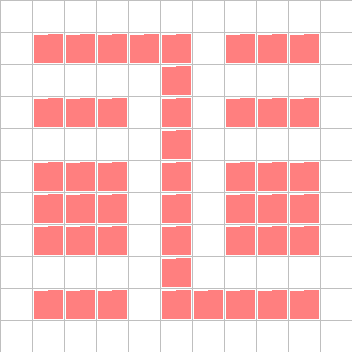

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


In [41]:
display(overlay)
np_overlay = np.array(overlay)
# np_overlay = np_overlay[:, :, 0]

# If the value is 255, replace by 1, else 0
np_overlay = np.where(np_overlay[:, :, 0] == 255, 1, 0)
print(np_overlay[:60, :60])